In [50]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import math 

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Gráficos
# ==============================================================================
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Asunciones y Preprocesamiento
# ==============================================================================
from scipy import stats
import math
from scipy.stats import levene
import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools

# ANOVA
# ==============================================================================
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA

#Linear Regresion con Sklearn
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Tamaño gráficas
# ==============================================================================
plt.rcParams["figure.figsize"] = (10,8)

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler,OneHotEncoder

## Abrimos el CSV

In [51]:
df= pd.read_csv("Bicicletas_limpio.csv", index_col = 0)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,spring,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,spring,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,spring,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,spring,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


## OUTLIERS

In [52]:
#Obtenemos las columnas numéricas
numericas = df.select_dtypes(include=np.number)

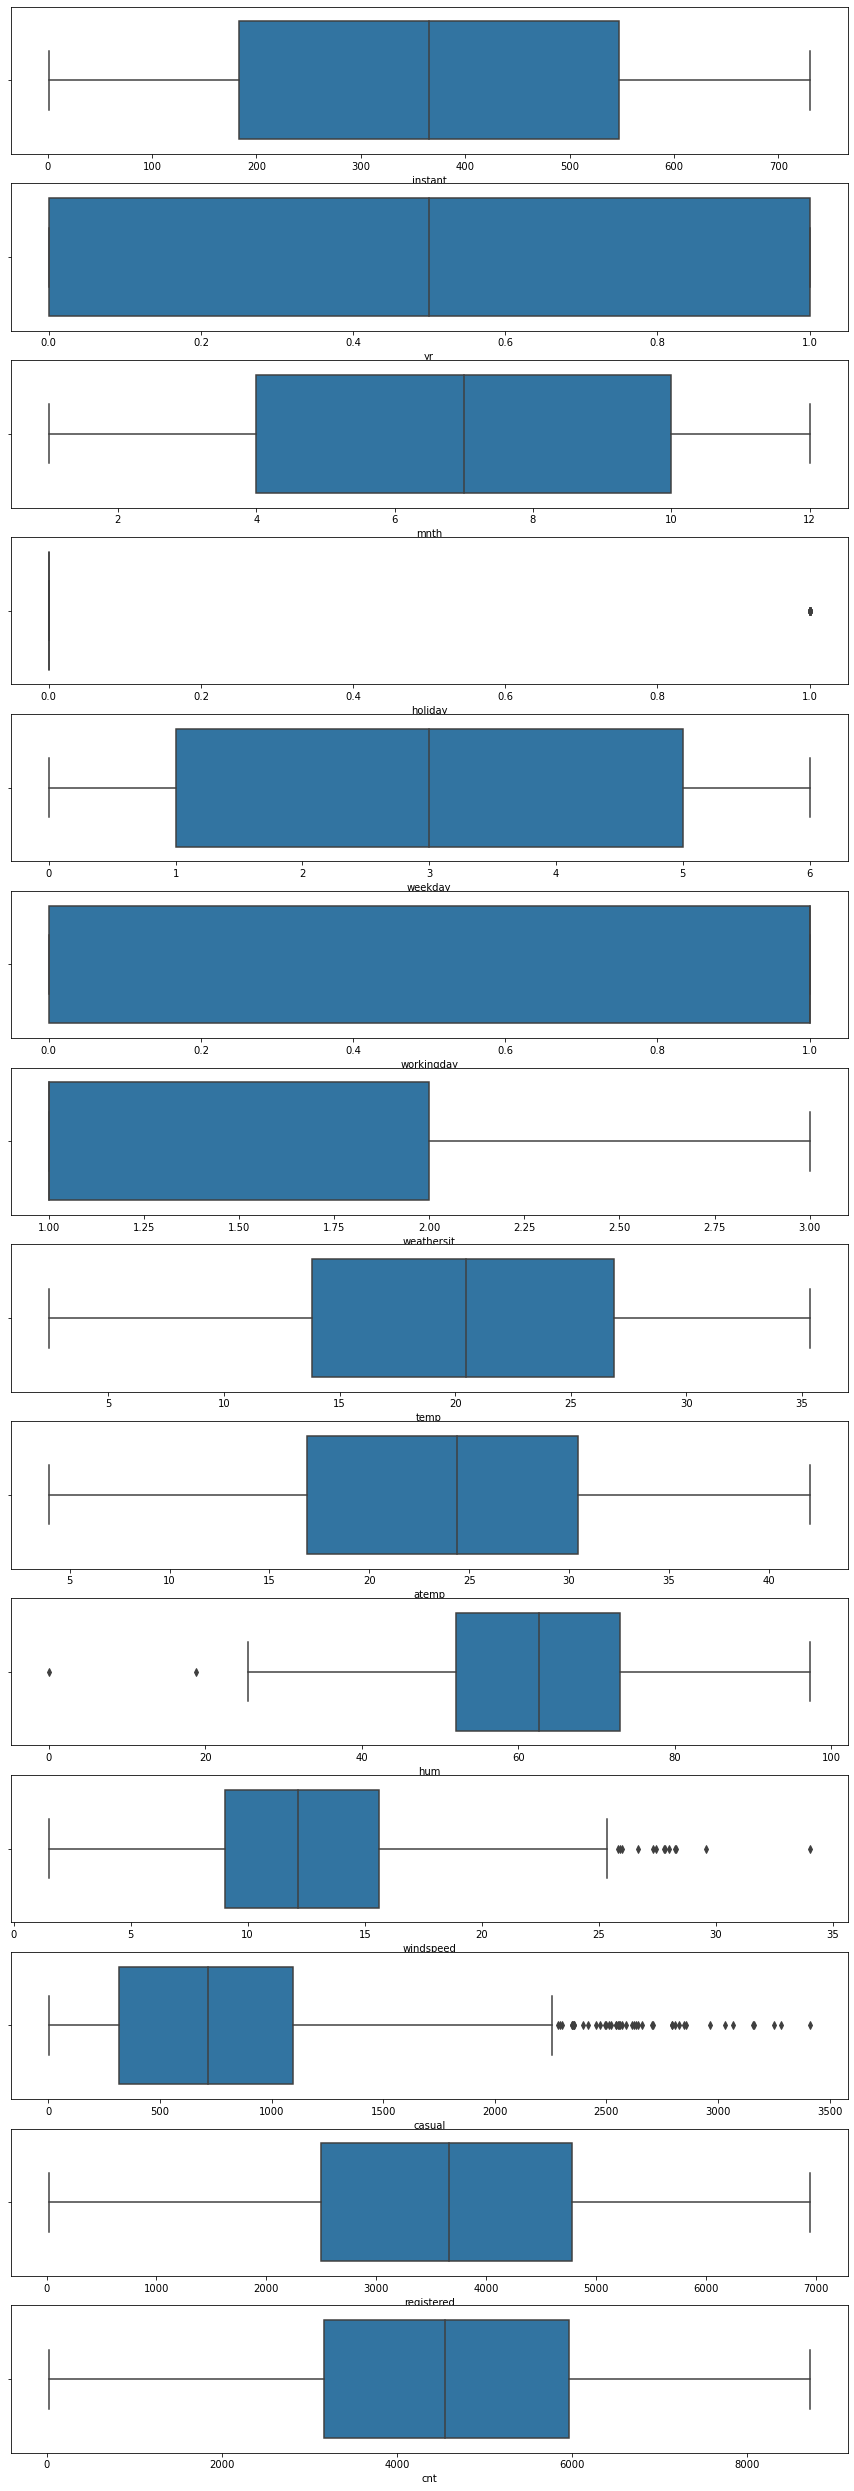

In [53]:
fig, axes = plt.subplots(14, 1, figsize=(15,45))

for i, col in enumerate(numericas):
    sns.boxplot(x = numericas.columns[i], data = df, ax=axes[i]); # para trazar una línea de densidad

plt.show()

- Observamos outliers en las variables de **hum, windspeed y casual**. Pero decidimos no reemplazarlos ya que podria darnos información sobre por ejemplo, los días con más viento, si afecta o no al alquiler de bicis. LOs outliers en casual también son informativos ya que veremos que días han alquilado más bicis personas que no están registradas.

- También elegimos no usar las variables **instant** y **dteday** porque no van a influir mucho en las demás, por lo que pasamos a eliminarlas de nuestro df.

In [54]:
df = df.drop(columns=['instant', 'dteday'])

- Elegimos como nuestra ***variable respuesta 'registered'***, queremos saber que relación tienen las demás variables

## Comprobaciones de asunciones

### Asunción de normalidad

| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

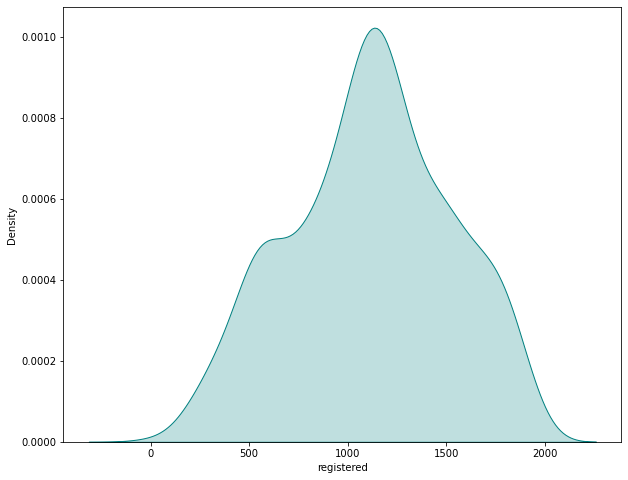

In [144]:
sns.distplot(df.registered, 
            hist = False, 
            color = 'teal', 
            kde_kws = {'shade':True, 'linewidth':1});

- A primera vista vemos que no siguen una distribución normal.

Comprobamos analíticamente

In [55]:
stats.shapiro(df["registered"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

In [56]:
#Mejoramos con una lambda ajustada con un boxcox la variable.
df['registered'], lambda_ajustada = stats.boxcox(df['registered']) 

In [150]:
df_copia = df.copy()

In [57]:
stats.shapiro(df["registered"])

ShapiroResult(statistic=0.9854231476783752, pvalue=1.1639369859040016e-06)

- Observamos que el p-valor es menor que 0.05 pero mejorado.Por lo tanto, nuestra variable no cumple la asunción de normalidad, los datos no siguen una distribución normal.

### Asunción de homocedasticidad

Las varianzas no difieren entre las distintas categorías de nuestros datos


| Test Levene  |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

In [58]:
def datos_test_levene(columna, df):
    valores = df[columna].unique()
    d = {}
    for x in valores:
        d["{0}".format(x)] = df[df[columna] == x]["registered"]
    return d

In [59]:
df_numericas = df.select_dtypes(include=np.number)

In [60]:
resultados = {}

numer = df_numericas.columns.drop(['registered'])

for col in numer:
    stat, p_valor = levene(df[col], df.registered, center='median')

    resultados[col] = p_valor

In [61]:
resultados

{'yr': 1.2393456002655248e-209,
 'mnth': 2.513642375761265e-207,
 'holiday': 4.549315183402299e-210,
 'weekday': 1.6724126346896994e-208,
 'workingday': 8.398163903132695e-210,
 'weathersit': 9.920248770218867e-210,
 'temp': 4.9863609107084916e-204,
 'atemp': 1.4373669749579232e-203,
 'hum': 3.4535570369733107e-199,
 'windspeed': 2.6313738118076603e-206,
 'casual': 3.2940518336607368e-18,
 'cnt': 1.7821069623506258e-150}

- Observamos que el p-valor es muy bajo, por lo tanto los valores no son homocedasticos, es decir, son heterogéneos.

### Asunción de independencia


| Test Independencia |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

In [62]:
combinaciones = list(itertools.combinations(df.columns, 2))
combinaciones

[('season', 'yr'),
 ('season', 'mnth'),
 ('season', 'holiday'),
 ('season', 'weekday'),
 ('season', 'workingday'),
 ('season', 'weathersit'),
 ('season', 'temp'),
 ('season', 'atemp'),
 ('season', 'hum'),
 ('season', 'windspeed'),
 ('season', 'casual'),
 ('season', 'registered'),
 ('season', 'cnt'),
 ('yr', 'mnth'),
 ('yr', 'holiday'),
 ('yr', 'weekday'),
 ('yr', 'workingday'),
 ('yr', 'weathersit'),
 ('yr', 'temp'),
 ('yr', 'atemp'),
 ('yr', 'hum'),
 ('yr', 'windspeed'),
 ('yr', 'casual'),
 ('yr', 'registered'),
 ('yr', 'cnt'),
 ('mnth', 'holiday'),
 ('mnth', 'weekday'),
 ('mnth', 'workingday'),
 ('mnth', 'weathersit'),
 ('mnth', 'temp'),
 ('mnth', 'atemp'),
 ('mnth', 'hum'),
 ('mnth', 'windspeed'),
 ('mnth', 'casual'),
 ('mnth', 'registered'),
 ('mnth', 'cnt'),
 ('holiday', 'weekday'),
 ('holiday', 'workingday'),
 ('holiday', 'weathersit'),
 ('holiday', 'temp'),
 ('holiday', 'atemp'),
 ('holiday', 'hum'),
 ('holiday', 'windspeed'),
 ('holiday', 'casual'),
 ('holiday', 'registered'),


In [63]:
for par in combinaciones:
    crosstab, test_results, expected = rp.crosstab(df[par[0]], df[par[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    print("---------------------------------", par[0], par[1], "---------------------------------")
    print(test_results)

--------------------------------- season yr ---------------------------------
                Chi-square test  results
0  Pearson Chi-square ( 3.0) =       0.0
1                    p-value =       1.0
2                 Cramer's V =       0.0
--------------------------------- season mnth ---------------------------------
                 Chi-square test   results
0  Pearson Chi-square ( 33.0) =   1762.002
1                     p-value =      0.000
2                  Cramer's V =      0.897
--------------------------------- season holiday ---------------------------------
                Chi-square test  results
0  Pearson Chi-square ( 3.0) =    1.5184
1                    p-value =    0.6780
2                 Cramer's V =    0.0456
--------------------------------- season weekday ---------------------------------
                 Chi-square test  results
0  Pearson Chi-square ( 18.0) =    0.4845
1                     p-value =    1.0000
2                  Cramer's V =    0.0149
--------

Al revisar los resultados observamos que:
- La mayoria de los p-valoresson mayores que 0.05 por lo tanto por cada combinación de 2 que hemos hecho son independientes entre ellas.
- V de Cramer representa la asociación de variables igual a 1 es el máximo y el valor mínimo es 0  que indica NO asociación.

## ANOVA

In [64]:
lm = ols('registered ~ season  + yr + mnth + holiday + weekday  + workingday + weathersit + temp + atemp + hum + windspeed', data=df).fit()
sm.stats.anova_lm(lm)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     269.4
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          2.81e-265
Time:                        14:01:02   Log-Likelihood:                -4778.9
No. Observations:                 730   AIC:                             9586.
Df Residuals:                     716   BIC:                             9650.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          665.5201     63.240     10.524      0.000     541.362     789.678
season[T.spring]  -196.6371     34.612     -5.681      0.000    -264.590    -128.685
season[T.summer]    15.5652     23.069      0.675      0.500     -29.726      60.857
season[T.winter]   176.0319     27.630      6.371      0.000     121.786     230.278
yr                 452.7822     12.779     35.432      0.000     427.694     477.871
mnth                -3.4109      3.386     -1.007      0.314     -10.059       3.237
holiday            -72.4064     39.263     -1.844      0.066    -149.490       4.677
weekday             10.8727      3.181      3.418      0.001       4.628      17.117
workingday         245.3389     14.069     17.438      0.000     217.717     272.961
weathersit        -133.6914     15.331     -8.720      0.000    -163.791    -103.592
temp                12.9095      7.057      1.829      0.068      -0.945      26.764
atemp                7.9206      6.318      1.254      0.210      -4.483      20.325
hum                 -1.8610      0.618     -3.013      0.003      -3.074      -0.648
windspeed           -7.7106      1.336     -5.770      0.000     -10.334      -5.087
==============================================================================
Omnibus:                      244.216   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1160.957
Skew:                          -1.454   Prob(JB):                    7.97e-253
Kurtosis:                       8.451   Cond. No.                         814.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Observarmos que **|P>|t|** que es **p-valor** hay algunas variables que pueden no interesarnos ya que son mayores a 0.05 por lo que puede que no influyan en nuestra variable respuesta. 

## Vamos a ir comprobando de diferentes formas como queda el modelo en la regresión

### Hacemos el modelo sin reemplazar outliers y sin categorizar 

In [65]:
#df = df.drop(columns = ['instant', 'dteday'])

In [66]:
df.dtypes

season         object
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered    float64
cnt             int64
dtype: object

- No incluimos la variable categórica 'season'

In [67]:
numericas = df.select_dtypes(include=np.number)

In [68]:
x = numericas.drop('registered', axis=1) #Eliminamos nuestra variable respuesta.
y = numericas[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,11.790859,204.583122,14.303256,0.998609,test
1,14.822812,388.017294,19.698155,0.997748,train


### Vemos como queda sin variable categórica y sin otras variables que no tienen sentido compararlas con nuestra variable registrados.

In [69]:
x = numericas.drop(columns = ['registered', 'casual', 'cnt']) 
y = numericas[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,129.052217,26962.826733,164.203614,0.816697,test
1,141.743979,37957.933824,194.827960,0.779678,train


- Obtenemos mejo R2 sin la variable categóricas pero eliminando otras variables. Pero las métricas son bastantes malas.

### Incluimos la variable categórica codificandola con un mapa

In [70]:
df_mapa = df.copy()

In [71]:
mapa_season = {"spring": 0,"summer": 1, "autumn": 2, "winter": 3} #asigno a cada estacion un valor
df_mapa["season"] = df_mapa["season"].map(mapa_season)#asigno a la columna los valores

In [72]:
x = df_mapa.drop(columns = ['registered', 'casual', 'cnt']) 
y = df_mapa[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,118.696434,21187.745689,145.560110,0.855958,test
1,133.006757,33112.714975,181.968995,0.807801,train


- Hemos obtenido con la variable categórica peor R2 en el cojunto de entrenamiento pero mejor en el conjunto de test. Aunque las demás métricas son bastantes malas, veremos si podemos mejorarlo

In [73]:
df_dummies = df.copy()

In [74]:
dummies_season = pd.get_dummies(df_dummies['season'], prefix_sep= '_', prefix='season', dtype='int')

In [75]:
df_dummies[dummies_season.columns] = dummies_season

In [76]:
df_dummies.drop(['season'], axis=1, inplace=True)

In [77]:
x = df_dummies.drop(columns = ['registered', 'casual', 'cnt']) 
y = df_dummies[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,116.309173,20438.427627,142.963029,0.861052,test
1,125.493562,30615.082903,174.971663,0.822298,train


    Parece que mejora algo más el R2 codificando con dummies.

- Estadarizamos sin categorizar.

In [78]:
df_estandarizado2 = df_mapa.copy()

In [79]:
df_estandarizado = df_dummies.copy()

In [80]:
st = StandardScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(df_estandarizado))
x_tranformadas.columns = df_estandarizado.columns
df_estandarizado[x_tranformadas.columns] = x_tranformadas
df_estandarizado.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_autumn,season_spring,season_summer,season_winter
0,-1.0,-1.602745,-0.172102,1.497785,-1.469753,1.112127,-0.827613,-0.680818,1.252343,-0.387833,-0.755455,-2.070540,-1.820972,-0.588951,1.748015,-0.580514,-0.567859
1,-1.0,-1.602745,-0.172102,-1.495052,-1.469753,1.112127,-0.722069,-0.741507,0.480996,0.748899,-1.046996,-2.057149,-1.916078,-0.588951,1.748015,-0.580514,-0.567859
2,-1.0,-1.602745,-0.172102,-0.996246,0.680387,-0.724644,-1.635432,-1.750344,-1.338073,0.745931,-1.063031,-1.615090,-1.632827,-0.588951,1.748015,-0.580514,-0.567859
3,-1.0,-1.602745,-0.172102,-0.497440,0.680387,-0.724644,-1.615560,-1.610886,-0.261577,-0.389769,-1.080523,-1.447463,-1.522732,-0.588951,1.748015,-0.580514,-0.567859
4,-1.0,-1.602745,-0.172102,0.001367,0.680387,-0.724644,-1.468226,-1.505615,-1.340294,-0.046477,-1.118424,-1.400590,-1.503090,-0.588951,1.748015,-0.580514,-0.567859


In [81]:
st = StandardScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(df_estandarizado2))
x_tranformadas.columns = df_estandarizado2.columns
df_estandarizado2[x_tranformadas.columns] = x_tranformadas
df_estandarizado2.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,-1.350819,-1.0,-1.602745,-0.172102,1.497785,-1.469753,1.112127,-0.827613,-0.680818,1.252343,-0.387833,-0.755455,-2.070540,-1.820972
1,-1.350819,-1.0,-1.602745,-0.172102,-1.495052,-1.469753,1.112127,-0.722069,-0.741507,0.480996,0.748899,-1.046996,-2.057149,-1.916078
2,-1.350819,-1.0,-1.602745,-0.172102,-0.996246,0.680387,-0.724644,-1.635432,-1.750344,-1.338073,0.745931,-1.063031,-1.615090,-1.632827
3,-1.350819,-1.0,-1.602745,-0.172102,-0.497440,0.680387,-0.724644,-1.615560,-1.610886,-0.261577,-0.389769,-1.080523,-1.447463,-1.522732
4,-1.350819,-1.0,-1.602745,-0.172102,0.001367,0.680387,-0.724644,-1.468226,-1.505615,-1.340294,-0.046477,-1.118424,-1.400590,-1.503090


In [82]:
x = df_estandarizado.drop(columns = ['registered', 'casual', 'cnt']) 
y = df_estandarizado[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,0.284240,0.122065,0.349378,0.861052,test
1,0.306685,0.182843,0.427601,0.822298,train


In [83]:
x = df_estandarizado2.drop(columns = ['registered', 'casual', 'cnt']) 
y = df_estandarizado2[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,0.290074,0.126540,0.355724,0.855958,test
1,0.325046,0.197759,0.444702,0.807801,train


- Obtenemos un R2 más alto que los anteriores y nuestras demás métricas son buenas. Hay un error de 0.3 y 0.4. Bastante bajos.

### Codificamos y volvemos a estandarizar

In [84]:
df_dummies['mnth'] = df_dummies['mnth'].astype('category')
df_dummies['yr'] = df_dummies['yr'].astype('category')
df_dummies['holiday'] = df_dummies['holiday'].astype('category')

In [85]:
df_dummies["weekday"] = df_dummies["weekday"].astype('category')
df_dummies["workingday"] = df_dummies["workingday"].astype('category')
df_dummies["weathersit"] = df_dummies["weathersit"].astype('category')

In [86]:
df_estand_cate = df_dummies.copy()

In [87]:
st = StandardScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(df_estand_cate))
x_tranformadas.columns = df_estand_cate.columns
df_estandarizado[x_tranformadas.columns] = x_tranformadas
df_estandarizado.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_autumn,season_spring,season_summer,season_winter
0,-1.0,-1.602745,-0.172102,1.497785,-1.469753,1.112127,-0.827613,-0.680818,1.252343,-0.387833,-0.755455,-2.070540,-1.820972,-0.588951,1.748015,-0.580514,-0.567859
1,-1.0,-1.602745,-0.172102,-1.495052,-1.469753,1.112127,-0.722069,-0.741507,0.480996,0.748899,-1.046996,-2.057149,-1.916078,-0.588951,1.748015,-0.580514,-0.567859
2,-1.0,-1.602745,-0.172102,-0.996246,0.680387,-0.724644,-1.635432,-1.750344,-1.338073,0.745931,-1.063031,-1.615090,-1.632827,-0.588951,1.748015,-0.580514,-0.567859
3,-1.0,-1.602745,-0.172102,-0.497440,0.680387,-0.724644,-1.615560,-1.610886,-0.261577,-0.389769,-1.080523,-1.447463,-1.522732,-0.588951,1.748015,-0.580514,-0.567859
4,-1.0,-1.602745,-0.172102,0.001367,0.680387,-0.724644,-1.468226,-1.505615,-1.340294,-0.046477,-1.118424,-1.400590,-1.503090,-0.588951,1.748015,-0.580514,-0.567859


In [88]:
x = df_estand_cate.drop(columns = ['registered', 'casual', 'cnt']) 
y = df_estand_cate[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,116.309173,20438.427627,142.963029,0.861052,test
1,125.493562,30615.082903,174.971663,0.822298,train


- Al categorizar algunas de nuestras variables la métrica vuelve a ser mucho peor, tendremos un margen de error bastante grande por lo que elegimos mejor no categorizar.

### VIF

In [89]:
def get_VIF(dataframe, target):
        X = add_constant(dataframe.loc[:, dataframe.columns != target])
        seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,).sort_values(ascending= False)
        return seriesObject

In [90]:
get_VIF(df_estandarizado,'registered')

season_winter          inf
season_summer          inf
season_spring          inf
season_autumn          inf
temp             71.435232
atemp            66.821206
cnt               9.608703
casual            6.010899
mnth              3.438728
workingday        3.138069
yr                2.884768
hum               1.986696
weathersit        1.938942
windspeed         1.292986
holiday           1.101205
weekday           1.054259
const             1.000000
dtype: float64

- Observamos que temp, atemp, cnt y casual tienen una multicolinealidad por encima de 5, por lo tanto tienen una colinealida severa con los demás datos, pasaremos a eliminarlos poco a poco.

In [91]:
get_VIF(df_estandarizado.drop(columns = ['temp','atemp']),'registered')

season_autumn         inf
season_spring         inf
season_summer         inf
season_winter         inf
cnt              8.504283
casual           5.939928
mnth             3.434253
workingday       3.105009
yr               2.622877
weathersit       1.935529
hum              1.860949
windspeed        1.232649
holiday          1.092413
weekday          1.040641
const            1.000000
dtype: float64

In [92]:
get_VIF(df_estandarizado.drop(columns = ['temp','atemp', 'casual', 'cnt']),'registered')

season_autumn         inf
season_spring         inf
season_summer         inf
season_winter         inf
mnth             3.428152
hum              1.860145
weathersit       1.685377
windspeed        1.171519
holiday          1.082291
workingday       1.073285
weekday          1.017904
yr               1.016316
const            1.000000
dtype: float64

### Probamos a eliminar en nuestro modelo también las variables indicadas en el VIF.

In [93]:
x = df_estandarizado.drop(columns = ['registered', 'casual', 'cnt', 'atemp', 'temp']) 
y = df_estandarizado[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,0.327726,0.179335,0.423480,0.795861,test
1,0.354646,0.226826,0.476263,0.779552,train


- Al eliminar temp y atemp el modelo empeora tanto en r2 como en margen de error, probemos a eliminar solo una, en este caso 'atemp' ya que en el MANOVA salía con un p-valor mucho mayor que 0.05 por lo que esta muy correlacionado con las demás variables(no es independiente).

In [94]:
x = df_estandarizado.drop(columns = ['registered', 'casual', 'cnt','atemp']) 
y = df_estandarizado[['registered']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,0.285344,0.122987,0.350695,0.860003,test
1,0.306901,0.182858,0.427619,0.822284,train


- El modelo ha mejorado significativamente, asi que quitaremos atemp y dejaremos temp. Ahora pasamos a comprobar si nuestro modelo es correcto

## Conclusión

El mejor modelo es:
- Sin reemplazar outliers
- Codificando 'season' con dummies
- Sin categorizar
- Estandarizando con StandarScale
- Obviamos las variables 'cnt', 'casual' y 'atemp'

### Probamos nuestro modelo

In [95]:
df_estandarizado

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_autumn,season_spring,season_summer,season_winter
0,-1.0,-1.602745,-0.172102,1.497785,-1.469753,1.112127,-0.827613,-0.680818,1.252343,-0.387833,-0.755455,-2.070540,-1.820972,-0.588951,1.748015,-0.580514,-0.567859
1,-1.0,-1.602745,-0.172102,-1.495052,-1.469753,1.112127,-0.722069,-0.741507,0.480996,0.748899,-1.046996,-2.057149,-1.916078,-0.588951,1.748015,-0.580514,-0.567859
2,-1.0,-1.602745,-0.172102,-0.996246,0.680387,-0.724644,-1.635432,-1.750344,-1.338073,0.745931,-1.063031,-1.615090,-1.632827,-0.588951,1.748015,-0.580514,-0.567859
3,-1.0,-1.602745,-0.172102,-0.497440,0.680387,-0.724644,-1.615560,-1.610886,-0.261577,-0.389769,-1.080523,-1.447463,-1.522732,-0.588951,1.748015,-0.580514,-0.567859
4,-1.0,-1.602745,-0.172102,0.001367,0.680387,-0.724644,-1.468226,-1.505615,-1.340294,-0.046477,-1.118424,-1.400590,-1.503090,-0.588951,1.748015,-0.580514,-0.567859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1.0,1.587648,-0.172102,0.500173,0.680387,1.112127,-1.319509,-1.521749,0.177576,2.059845,-0.877902,-1.150334,-1.237414,-0.588951,1.748015,-0.580514,-0.567859
726,1.0,1.587648,-0.172102,0.998979,0.680387,1.112127,-1.324068,-1.347378,-0.264634,-0.452029,-0.299193,-0.747954,-0.730355,-0.588951,1.748015,-0.580514,-0.567859
727,1.0,1.587648,-0.172102,1.497785,-1.469753,1.112127,-1.324068,-1.425011,0.880424,-0.853182,-1.006180,-1.650721,-1.636962,-0.588951,1.748015,-0.580514,-0.567859
728,1.0,1.587648,-0.172102,-1.495052,-1.469753,-0.724644,-1.310404,-1.490698,-1.014341,2.067858,-0.707351,-1.463653,-1.401782,-0.588951,1.748015,-0.580514,-0.567859


In [122]:
X = df_estandarizado.drop(['atemp', 'casual', 'registered', 'cnt'], axis =1)
y = df_estandarizado[['registered']]

In [123]:
X_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [124]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [125]:
y_pred_test = lr.predict(x_test)
y_pred_train = lr.predict(X_train)

In [126]:
def metricas(y_test, y_train, y_test_pred, y_train_pred): 
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), 
                          metrics.mean_absolute_error(y_train, y_train_pred)], 
                  'MSE': [metrics.mean_squared_error(y_test, y_test_pred), 
                          metrics.mean_squared_error(y_train, y_train_pred)], 
                  'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 
                           np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))], 
                  'R2': [metrics.r2_score(y_test, y_test_pred), 
                         metrics.r2_score(y_train, y_train_pred)], "set": ["test", "train"]} 
    df = pd.DataFrame(resultados) 
    return df 

In [127]:
X.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,season_autumn,season_spring,season_summer,season_winter
0,-1.0,-1.602745,-0.172102,1.497785,-1.469753,1.112127,-0.827613,1.252343,-0.387833,-0.588951,1.748015,-0.580514,-0.567859
1,-1.0,-1.602745,-0.172102,-1.495052,-1.469753,1.112127,-0.722069,0.480996,0.748899,-0.588951,1.748015,-0.580514,-0.567859
2,-1.0,-1.602745,-0.172102,-0.996246,0.680387,-0.724644,-1.635432,-1.338073,0.745931,-0.588951,1.748015,-0.580514,-0.567859
3,-1.0,-1.602745,-0.172102,-0.497440,0.680387,-0.724644,-1.615560,-0.261577,-0.389769,-0.588951,1.748015,-0.580514,-0.567859
4,-1.0,-1.602745,-0.172102,0.001367,0.680387,-0.724644,-1.468226,-1.340294,-0.046477,-0.588951,1.748015,-0.580514,-0.567859


In [137]:
#modelito = {'yr':[2], 'mnth':[8], 'holiday':[1], 'workingday':[1],'weekday':[4], 'weathersit':[1], 'temp':[38], 'hum':[30], 'windspeed':[10],'season_summer': [1],'season_winter': [0], 'season_autumn': [0], 'season_spring': [0]}

In [153]:
modelito = {'yr':[0], 'mnth':[1], 'holiday':[0], 'workingday':[0],'weekday':[6], 'weathersit':[2], 'temp':[14], 'hum':[80], 'windspeed':[10],'season_summer': [0],'season_winter': [0], 'season_autumn': [0], 'season_spring': [1]}

In [154]:
modelo = pd.DataFrame(modelito)

In [159]:
st = StandardScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(modelo))
x_tranformadas.columns = modelo.columns
modelo[x_tranformadas.columns] = x_tranformadas
modelo.head()

,yr,mnth,holiday,workingday,weekday,weathersit,temp,hum,windspeed,season_summer,season_winter,season_autumn,season_spring
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
lr.predict(modelo)

array([[-0.01234687]])

In [161]:
inversed = st.inverse_transform(modelo)
print(inversed)

[[ 0.  1.  0.  0.  6.  2. 14. 80. 10.  0.  0.  0.  1.]]


In [163]:
lr.predict(inversed)

array([[2.23356482]])

In [ ]:
scaler = StandardScaler()
print(scaler.fit(modelo))
StandardScaler()

scaler.transform(modelo)


